In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib

In [ ]:
# Path to the image file
main_directory = '/content/drive/MyDrive/project dataset/images'

# path for the directory
main_directory = pathlib.Path(main_directory)


In [ ]:
batch_size = 32
img_size = (180, 180)

dataset = image_dataset_from_directory(
    main_directory,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'  # Automatically label classes based on folder names
)

Found 6000 files belonging to 6 classes.


In [ ]:
# class names
class_names = dataset.class_names
print("Class names:", class_names)

image_file_paths = list(main_directory.glob('*/*'))

file_name_to_label = {}

for path in image_file_paths:
    file_name = path.name
    class_label = path.parent.name
    file_name_to_label[file_name] = class_names.index(class_label)


Class names: ['apple_pie', 'bread_pudding', 'cannoli', 'chicken_wings', 'eggs_benedict', 'french_toast']


In [ ]:
print("File names:")
for file_name, label in file_name_to_label.items():
    print(f"File: {file_name}, Label: {class_names[label]}")


Streaming output truncated to the last 5000 lines.
File: 125648.jpg, Label: cannoli
File: 1346877.jpg, Label: cannoli
File: 1087676.jpg, Label: cannoli
File: 1132912.jpg, Label: cannoli
File: 1240403.jpg, Label: cannoli
File: 1154845.jpg, Label: cannoli
File: 1248285.jpg, Label: cannoli
File: 1378086.jpg, Label: cannoli
File: 1315364.jpg, Label: cannoli
File: 106010.jpg, Label: cannoli
File: 1406840.jpg, Label: cannoli
File: 1185937.jpg, Label: cannoli
File: 1313520.jpg, Label: cannoli
File: 1089515.jpg, Label: cannoli
File: 1469129.jpg, Label: cannoli
File: 1361297.jpg, Label: cannoli
File: 1033496.jpg, Label: cannoli
File: 1066435.jpg, Label: cannoli
File: 1446392.jpg, Label: cannoli
File: 144231.jpg, Label: cannoli
File: 1094662.jpg, Label: cannoli
File: 1489240.jpg, Label: cannoli
File: 1464993.jpg, Label: cannoli
File: 1341141.jpg, Label: cannoli
File: 1456962.jpg, Label: cannoli
File: 1143473.jpg, Label: cannoli
File: 1194018.jpg, Label: cannoli
File: 1383142.jpg, Label: cannoli


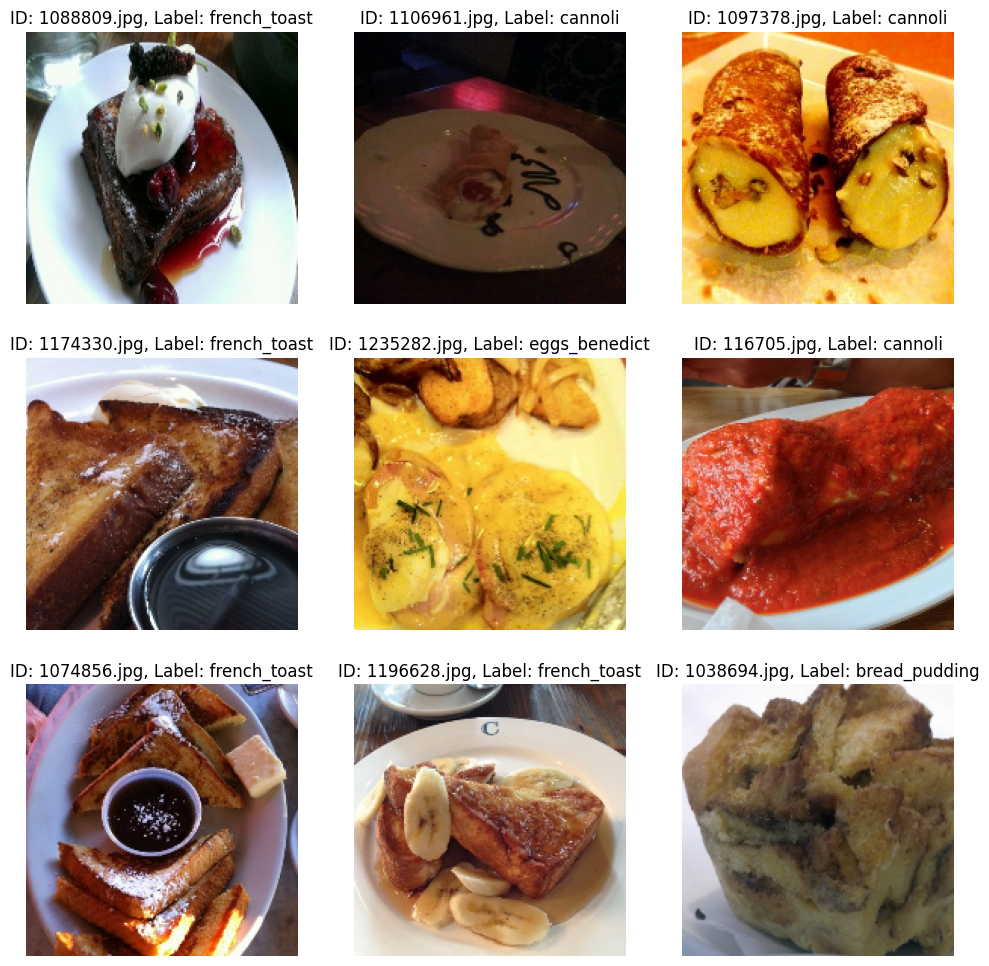

In [ ]:
# Plot of some images
plt.figure(figsize=(12, 12))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        file_name = image_file_paths[i].name
        label_id = labels[i].numpy()
        plt.title(f"ID: {file_name}, Label: {class_names[label_id]}")
        plt.axis("off")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

class_names = sorted([item.name for item in main_directory.glob('*') if item.is_dir()])
print("Class names:", class_names)

file_paths = []
labels = []

for class_name in class_names:
    class_dir = main_directory / class_name
    for img_path in class_dir.glob('*'):
        file_paths.append(str(img_path))
        labels.append(class_names.index(class_name))


print("File paths:", file_paths[:5])
print("Labels:", labels[:5])


Class names: ['apple_pie', 'bread_pudding', 'cannoli', 'chicken_wings', 'eggs_benedict', 'french_toast']
File paths: ['/content/drive/MyDrive/project dataset/images/apple_pie/1088809.jpg', '/content/drive/MyDrive/project dataset/images/apple_pie/1106961.jpg', '/content/drive/MyDrive/project dataset/images/apple_pie/1097378.jpg', '/content/drive/MyDrive/project dataset/images/apple_pie/1174330.jpg', '/content/drive/MyDrive/project dataset/images/apple_pie/1235282.jpg']
Labels: [0, 0, 0, 0, 0]


In [ ]:
# numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

# Splitting Data
train_x, temp_x, train_y, temp_y = train_test_split(file_paths, labels, test_size=0.2, random_state=123)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=123)
print(f"Training size: {len(train_x)}, Validation size: {len(val_x)}, Test size: {len(test_x)}")


Training size: 4800, Validation size: 600, Test size: 600


In [ ]:
# Function to convert the filenames and images
def load_and_preprocess_image(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [180, 180])
    img = img / 255.0  # Normalization
    return img, label

In [ ]:
# Tensor Slices
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

# mapping all images to the preprocess function
train_dataset = train_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)

# Batching
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
for images, labels in train_dataset.take(1):
    print(f'Image batch shape: {images.shape}')
    print(f'Label batch shape: {labels.shape}')

Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # First block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening and dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,221,574 (50.44 MB)

 Trainable params: 13,221,574 (50.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Training the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 688s 5s/step - accuracy: 0.2312 - loss: 1.8141 - val_accuracy: 0.3700 - val_loss: 1.5906
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 702s 4s/step - accuracy: 0.3552 - loss: 1.5889 - val_accuracy: 0.3917 - val_loss: 1.4957
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 677s 4s/step - accuracy: 0.4259 - loss: 1.4604 - val_accuracy: 0.4133 - val_loss: 1.4777
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 709s 4s/step - accuracy: 0.4726 - loss: 1.3418 - val_accuracy: 0.4367 - val_loss: 1.4487
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 661s 4s/step - accuracy: 0.5668 - loss: 1.1408 - val_accuracy: 0.4083 - val_loss: 1.5444
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.6314 - loss: 0.9692 - val_accuracy: 0.4300 - val_loss: 1.5738
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 663s 4s/step - accuracy: 0.7177 - loss: 0.7723 - val_accuracy: 0.4483 - val_loss: 1.8055
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 689s 4s/step - accuracy: 0.7620 - loss: 0.6467 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.4306 - loss: 2.1293
Test accuracy: 0.4266666769981384


In [ ]:
import numpy as np

# Example: Making predictions on a batch of test data
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compare predicted labels with true labels
    print(f"Predicted labels: {predicted_labels}")
    print(f"True labels: {labels.numpy()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Predicted labels: [1 3 4 0 4 1 1 2 2 0 1 4 4 3 2 4 0 0 0 4 0 2 1 4 1 3 0 0 0 1 0 2]
True labels: [4 5 1 4 4 1 2 0 2 1 1 5 4 3 1 5 1 0 1 3 4 1 3 0 0 3 3 2 5 1 1 3]


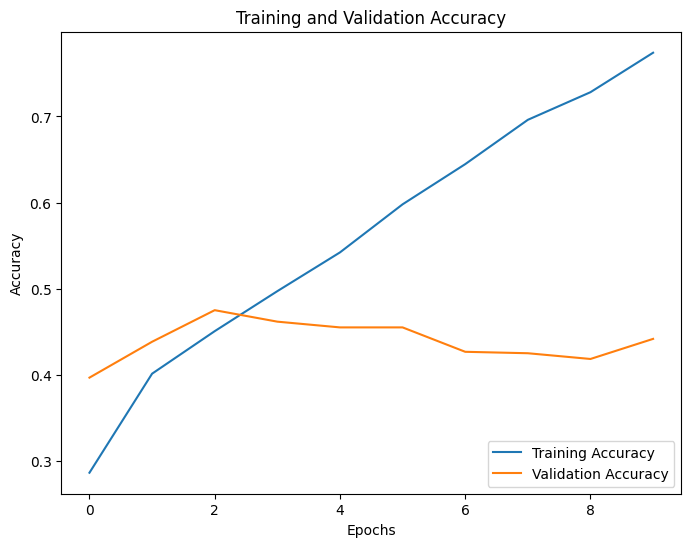

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation and test accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#test_acc = test_acc

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.plot(test_acc, label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # First block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening and dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,221,574 (50.44 MB)

 Trainable params: 13,221,574 (50.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping to stop training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.1966 - loss: 1.8396 - val_accuracy: 0.3250 - val_loss: 1.6207
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.2887 - loss: 1.6868 - val_accuracy: 0.3750 - val_loss: 1.5790
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.3567 - loss: 1.6004 - val_accuracy: 0.3933 - val_loss: 1.5294
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - accuracy: 0.3649 - loss: 1.5835 - val_accuracy: 0.3683 - val_loss: 1.5682
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.3794 - loss: 1.5558 - val_accuracy: 0.3750 - val_loss: 1.4994
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 60ms/step - accuracy: 0.3886 - loss: 1.5296 - val_accuracy: 0.4000 - val_loss: 1.4854
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - accuracy: 0.4034 - loss: 1.5070 - val_accuracy: 0.4400 - val_loss: 1.4284
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - accuracy: 0.3926 - loss: 1.5200 - 

In [ ]:
# L2 Regularization

from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    # First block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening and dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,221,574 (50.44 MB)

 Trainable params: 13,221,574 (50.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.1894 - loss: 3.0181 - val_accuracy: 0.1983 - val_loss: 1.8655
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.2484 - loss: 1.7662 - val_accuracy: 0.2750 - val_loss: 1.7233
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.2649 - loss: 1.7273 - val_accuracy: 0.3117 - val_loss: 1.6707
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - accuracy: 0.2937 - loss: 1.6811 - val_accuracy: 0.3250 - val_loss: 1.6539
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 79ms/step - accuracy: 0.2979 - loss: 1.6782 - val_accuracy: 0.2800 - val_loss: 1.6801
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.2946 - loss: 1.6738 - val_accuracy: 0.2667 - val_loss: 1.6498
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - accuracy: 0.2941 - loss: 1.6925 - val_accuracy: 0.2867 - val_loss: 1.6668
Epoch 8/10


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

# VGG16 pretrained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


In [ ]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 106s 236ms/step - accuracy: 0.1820 - loss: 1.9838 - val_accuracy: 0.2867 - val_loss: 1.7233
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 113s 107ms/step - accuracy: 0.2471 - loss: 1.7490 - val_accuracy: 0.3417 - val_loss: 1.6565
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.3046 - loss: 1.6804 - val_accuracy: 0.3933 - val_loss: 1.5882
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 80s 109ms/step - accuracy: 0.3474 - loss: 1.6165 - val_accuracy: 0.4600 - val_loss: 1.5181
Epoch 5/10


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")


In [ ]:
import numpy as np

for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    print(f"Predicted labels: {predicted_labels}")
    print(f"True labels: {labels.numpy()}")

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
